# This notebook builds a dog breed image classification model with TensorFlow & Resnet50 CNN architecture

In [1]:
# load the data

import pandas as pd
labels_csv = pd.read_csv('labels.csv')
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<AxesSubplot:>

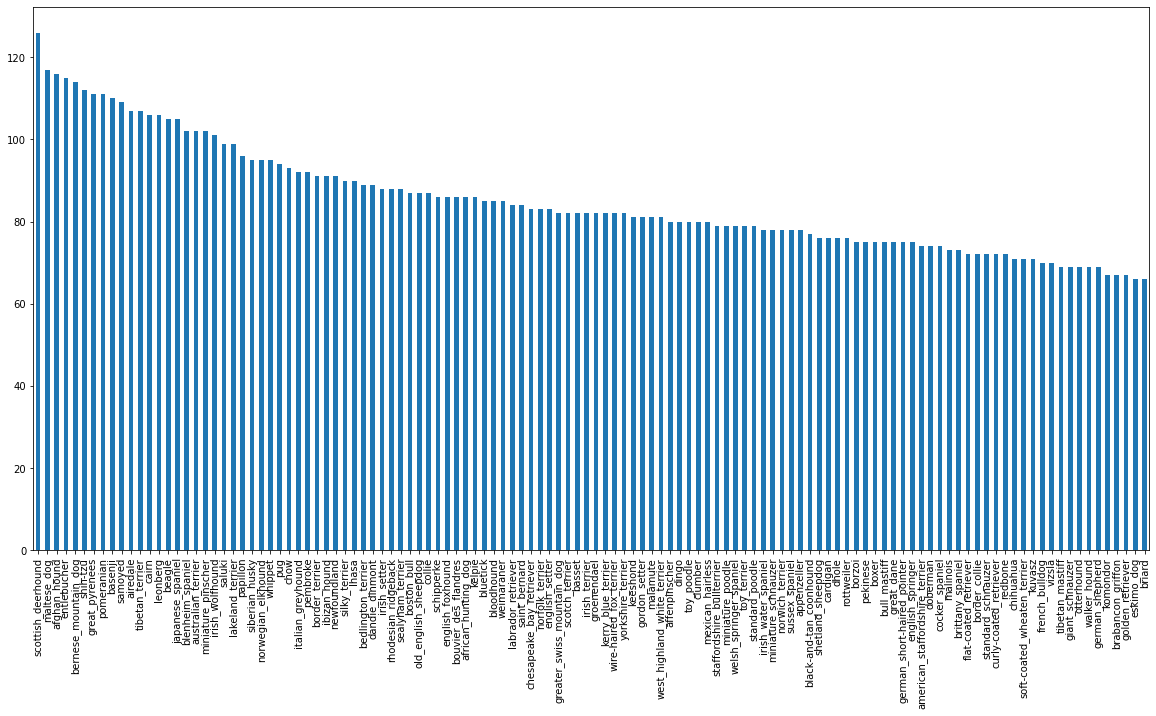

In [2]:
# visualize the data

labels_csv['breed'].value_counts().plot.bar(figsize=(20, 10))

## Getting images & their labels
    Make a list of all the file path names.
    Create the labels

In [3]:
# create path names from image IDs

filenames = ['train/' + fname + '.jpg' for fname in labels_csv['id']]


filenames[:2]

['train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'train/001513dfcb2ffafc82cccf4d8bbaba97.jpg']

In [4]:
# turn labels into numpy array

import numpy as np
labels = labels_csv['breed'].to_numpy()
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [5]:
# find the unique labels

unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [6]:
# turn labels into an array of booleans

boolean_labels = [label == unique_breeds for label in labels]
len(boolean_labels)

10222

In [7]:
# turn booleans into integers

boolean_labels[0].astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [8]:
# creating variables to grab the filenames & boolean_labels

x = filenames
y = boolean_labels

## Create training & validation set for the model
    Take 1000 images first & then increase as needed

In [9]:
# set the number of images

NUM_IMAGES = 1000

In [10]:
# split the data into train & validation set

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(x_train), len(x_val), len(y_train), len(y_val)

(800, 200, 800, 200)

## Preprocess the images
    Convert the images into tensors

In [11]:
# create a function to preprocess images

import tensorflow as tf
import tensorflow_hub as hub

IMG_SIZE = 224

def process_image(img_path, img_size=IMG_SIZE):
    """
    Takes an image path & converts it into a tensor
    """
    image = tf.io.read_file(img_path)
    tensor = tf.io.decode_jpeg(image, channels=3)
    color_channel = tf.image.convert_image_dtype(tensor, tf.float32)
    resized_image = tf.image.resize(color_channel, (img_size, img_size))

    return resized_image

In [13]:
process_image(x[1])

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.22176053, 0.1532646 , 0.12077089],
        [0.24290617, 0.17007563, 0.12532842],
        [0.25025794, 0.16272292, 0.10750583],
        ...,
        [0.4866906 , 0.31810695, 0.18481737],
        [0.46775866, 0.32910115, 0.20204483],
        [0.36027768, 0.2283099 , 0.11981372]],

       [[0.22331059, 0.14479166, 0.10454448],
        [0.20956516, 0.13433544, 0.08120592],
        [0.20576334, 0.11818807, 0.06297097],
        ...,
        [0.34747207, 0.21052358, 0.10098224],
        [0.25428382, 0.14531395, 0.05989731],
        [0.22268865, 0.11715643, 0.03506609]],

       [[0.21673436, 0.12777252, 0.0741048 ],
        [0.20701681, 0.11805496, 0.05878148],
        [0.22288738, 0.12433177, 0.0666433 ],
        ...,
        [0.19956292, 0.10319562, 0.05528758],
        [0.24323113, 0.17113218, 0.12510629],
        [0.17322922, 0.11525137, 0.08183777]],

       ...,

       [[0.71888185, 0.40606675, 0.10109472],
        [0.72

In [14]:
# function to create a tuple of image & label

def data_tuple(image_path, label):
    """
    Takes an image file path & the associated label, process the image & returns a tuple of image & label
    """
    image = process_image(image_path)
    
    return image, label

## Turn Data into batches of 32

In [15]:
# function to turn data into batches

BATCH_SIZE = 32

def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates betches of data out of image x & label y pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Accepts test data as input.
    """
    if test_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
        data_batch = data.map(process_image).batch(batch_size)
        return data_batch
    elif valid_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                                   tf.constant(y)))
        data_batch = data.map(data_tuple).batch(batch_size)
        return data_batch
    else:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                                   tf.constant(y)))
        shuffled_data = data.shuffle(buffer_size=len(x))
        data = data.map(data_tuple)
        data_batch = data.batch(batch_size)
        
    return data_batch

In [16]:
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)

In [18]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Build the model

In [19]:
# shape of the input

INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

# shape of the output

OUTPUT_SHAPE = len(unique_breeds)

# setup model from TensorFlow Hub

MODEL_URL = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4'

In [20]:
# function to build a Keras Model

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    
    # setup the model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL),  # input layer
        tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                              activation='softmax')  # output layer
    ])

    # compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy'])
    
    # build the model
    model.build(INPUT_SHAPE)
    
    return model

In [21]:
model = create_model()
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              25615849  
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 25,736,089
Trainable params: 120,240
Non-trainable params: 25,615,849
_________________________________________________________________


## Create callbacks

In [22]:
# TensorBoard callback

# load TensorBoard notebook extension

%load_ext tensorboard

In [27]:
import datetime
import os

# function to build TensorBoard callbacks


def create_tensorboard_callback():
    logdir = os.path.join('logs/',
                          datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    return tf.keras.callbacks.TensorBoard(logdir)

In [28]:
# create early stopping callback

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)

## Training the model
    The model is only going to train on 1000 images to make sure everything is working properly.

In [29]:
NUM_EPOCHS = 100

# function to train the model


def train_model():
    """
    Trains a model & returns the trained version
    """
    # create a model
    model = create_model()

    # create TensorBoard callback
    tensorboard = create_tensorboard_callback()

    # fit the model to the data & pass the callbacks
    model.fit(x=train_data,
                epochs=NUM_EPOCHS,
                validation_data=val_data,
                validation_freq=1,
                callbacks=[tensorboard, early_stopping])

    return model

In [30]:
# fit the model to the data

model = train_model()

Epoch 1/100
 1/25 [>.............................] - ETA: 0s - loss: 8.1069 - accuracy: 0.0312WARNING:tensorflow:From C:\Users\Abhik\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


25/25 [==============================] - 130s 5s/step - loss: 5.3209 - accuracy: 0.1225 - val_loss: 3.2221 - val_accuracy: 0.2850
Epoch 2/100
25/25 [==============================] - 111s 4s/step - loss: 1.1703 - accuracy: 0.7075 - val_loss: 2.0092 - val_accuracy: 0.5000
Epoch 3/100
25/25 [==============================] - 110s 4s/step - loss: 0.3705 - accuracy: 0.9425 - val_loss: 1.7610 - val_accuracy: 0.5400
Epoch 4/100
25/25 [==============================] - 111s 4s/step - loss: 0.1564 - accuracy: 0.9887 - val_loss: 1.7001 - val_accuracy: 0.5350
Epoch 5/100
25/25 [==============================] - 109s 4s/step - loss: 0.0950 - accuracy: 0.9975 - val_loss: 1.6703 - val_accuracy: 0.5700
Epoch 6/100
25/25 [==============================] - 108s 4s/step - loss: 0.0678 - accuracy: 1.0000 - val_loss: 1.6526 - val_accuracy: 0.5900
Epoch 7/100
25/25 [==============================] - 106s 4s/step - loss: 0.0525 - accuracy: 1.0000 - val_loss: 1.6402 - val_accuracy: 0.5950
Epoch 8/100
25/25 

## Make predictions

In [31]:
# make predictions on the validation data

predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 19s 3s/step


array([[1.6687263e-03, 1.2103058e-03, 1.6600027e-04, ..., 5.2192896e-05,
        4.7761383e-05, 3.8563801e-05],
       [5.2457544e-06, 4.4474458e-05, 4.3772277e-04, ..., 1.3041767e-05,
        2.0219249e-04, 8.8278887e-07],
       [2.2277698e-06, 3.0287326e-04, 4.1474756e-08, ..., 3.3902808e-07,
        7.6073036e-07, 2.5510138e-07],
       ...,
       [2.4972849e-05, 1.5793044e-05, 1.3037659e-05, ..., 1.8501070e-06,
        3.8270035e-05, 9.0557614e-06],
       [7.9603087e-06, 1.2534058e-06, 2.3345738e-07, ..., 4.1923404e-06,
        2.6941012e-07, 8.0899469e-04],
       [9.9251039e-08, 9.1904633e-07, 4.0873700e-09, ..., 5.8188951e-05,
        7.3741774e-08, 2.7322922e-06]], dtype=float32)

In [32]:
# turn prediction probabilities into their respective labels

def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label
    """
    return unique_breeds[np.argmax(prediction_probabilities)]

In [33]:
pred_label = get_pred_label(predictions[1])
pred_label

'scotch_terrier'

## Compare predictions with validation labels

In [34]:
# function to unbatch a batch dataset

def unbatch_dataset(data):
    """
    Takes batched dataset of Tensors & returns separate arrays of images & labels
    """

    images_ = []
    labels_ = []
    for image, label in data.unbatch().as_numpy_iterator():
        images_.append(image)
        labels_.append(label)
    
    return images_, labels_

val_images, val_labels = unbatch_dataset(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [35]:
get_pred_label(val_labels[19])

'irish_water_spaniel'

In [36]:
get_pred_label(predictions[19])

'irish_water_spaniel'

In [44]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 5952), started 8:20:15 ago. (Use '!kill 5952' to kill it.)

## Train the model on the full data

In [45]:
# create a data batch with full data

full_data = create_data_batches(x, y)

In [46]:
len(full_data)

320

In [47]:
# create model on full data

full_model = create_model()

In [48]:
# create model callbacks

full_model_tensorboard = create_tensorboard_callback()

full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                             patience=3)

In [49]:
# fit the model to the full data

full_model.fit(x=full_data,
              epochs=NUM_EPOCHS,
              callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
  2/320 [..............................] - ETA: 1:07:12 - loss: 7.2535 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 3.5884s vs `on_train_batch_end` time: 21.7756s). Check your callbacks.


320/320 [==============================] - 1180s 4s/step - loss: 1.7318 - accuracy: 0.5862
Epoch 2/100
320/320 [==============================] - 1114s 3s/step - loss: 0.7290 - accuracy: 0.7845
Epoch 3/100
320/320 [==============================] - 1125s 4s/step - loss: 0.4635 - accuracy: 0.8643
Epoch 4/100
320/320 [==============================] - 1121s 4s/step - loss: 0.3164 - accuracy: 0.9116
Epoch 5/100
320/320 [==============================] - 1121s 4s/step - loss: 0.2308 - accuracy: 0.9418
Epoch 6/100
320/320 [==============================] - 1116s 3s/step - loss: 0.1709 - accuracy: 0.9620
Epoch 7/100
320/320 [==============================] - 1117s 3s/step - loss: 0.1288 - accuracy: 0.9754
Epoch 8/100
320/320 [==============================] - 1119s 3s/step - loss: 0.1004 - accuracy: 0.9826
Epoch 9/100
320/320 [==============================] - 1139s 4s/step - loss: 0.0774 - accuracy: 0.9894
Epoch 10/100
320/320 [==============================] - 1118s 3s/step - loss: 0.0620 

## Save & load models

In [50]:
# function to save a model

def save_model(model, suffix=None):
    modeldir = os.path.join('models/',
                           datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    model_path = modeldir + '-' + suffix + '.h5'
    model.save(model_path)
    return model_path

In [51]:
# function to load model

def load_model(model_path):
    model = tf.keras.models.load_model(model_path,
                                      custom_objects={'KerasLayer':hub.KerasLayer})
    return model

In [52]:
save_model(model, suffix='100-images-resnet50v2')

'models/20210226-071019-100-images-resnet50v2.h5'

In [53]:
save_model(full_model, suffix='full-data-resnet50v2')

'models/20210226-071057-full-data-resnet50v2.h5'

In [55]:
loaded_full_model = load_model('models/20210226-071057-full-data-resnet50v2.h5')

## Make predictions with the model trained on full dataset

In [58]:
# make predictions on validation data

test_predictions = loaded_full_model.predict(val_data, verbose=1)
test_predictions

7/7 [==============================] - 19s 3s/step


array([[3.38793593e-09, 2.20119672e-10, 4.53338166e-11, ...,
        6.96581139e-08, 1.75057191e-09, 9.12178066e-09],
       [3.40959919e-19, 8.71534561e-14, 2.86950609e-19, ...,
        8.06130546e-20, 3.62434641e-15, 4.31441890e-17],
       [2.21317807e-21, 2.04365778e-12, 1.23919345e-16, ...,
        2.10774705e-15, 4.02297466e-12, 8.71418811e-18],
       ...,
       [2.30459150e-23, 2.05018142e-18, 1.40304756e-21, ...,
        7.36936448e-19, 2.04370726e-19, 6.75114210e-19],
       [2.90689968e-07, 1.05763897e-14, 1.85830165e-13, ...,
        1.98896468e-13, 9.72317893e-10, 2.72347529e-06],
       [3.34287251e-11, 8.02686571e-14, 1.16540883e-11, ...,
        4.31068975e-06, 1.21725325e-05, 1.20056090e-10]], dtype=float32)

In [199]:
test_predictions.shape

(200, 120)

In [211]:
get_pred_label(val_labels[1])

'scotch_terrier'

In [212]:
get_pred_label(test_predictions[1])

'scotch_terrier'

In [167]:
from sklearn.metrics import accuracy_score

In [215]:
accuracy_score(np.argmax(val_labels, axis=1), test_predictions.argmax(axis=1))

0.87

## Make predictions on test data

In [113]:
# get custom image file paths

test_image_paths = ['test/' + fname for fname in os.listdir('test/')]
test_image_paths[:5]

['test/000621fb3cbb32d8935728e48679680e.jpg',
 'test/00102ee9d8eb90812350685311fe5890.jpg',
 'test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 'test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 'test/001a5f3114548acdefa3d4da05474c2e.jpg']

In [114]:
# turn test data into batch datasets

test_data = create_data_batches(test_image_paths, test_data=True)
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [120]:
# make predictions

test_preds = loaded_full_model.predict(test_data, verbose=1)
test_preds

324/324 [==============================] - 1155s 4s/step


array([[1.1983058e-14, 3.6724932e-19, 7.4773953e-19, ..., 4.6296927e-21,
        9.7331624e-16, 1.8859396e-15],
       [2.3905362e-14, 2.1419780e-16, 4.5119071e-18, ..., 1.2010092e-16,
        6.6303039e-16, 1.1666446e-17],
       [2.2603410e-13, 2.2929629e-07, 2.3779715e-12, ..., 1.5843011e-11,
        7.3700974e-13, 2.8103596e-12],
       ...,
       [3.1124948e-15, 6.4667264e-18, 6.3856060e-12, ..., 7.8968929e-09,
        1.1847545e-15, 5.1736010e-15],
       [6.6999445e-10, 4.6974661e-18, 9.9782083e-17, ..., 2.3918144e-15,
        6.9094893e-13, 1.8263377e-12],
       [4.5579071e-16, 4.5185194e-10, 2.3083103e-13, ..., 2.8203282e-11,
        5.1424133e-16, 2.8274115e-18]], dtype=float32)

In [216]:
# get test prediction labels

test_pred_labels = [get_pred_label(test_preds[i]) for i in range(len(test_preds))]
test_pred_labels

['japanese_spaniel',
 'samoyed',
 'clumber',
 'newfoundland',
 'lhasa',
 'chow',
 'australian_terrier',
 'samoyed',
 'scottish_deerhound',
 'newfoundland',
 'tibetan_terrier',
 'sealyham_terrier',
 'newfoundland',
 'pomeranian',
 'chihuahua',
 'leonberg',
 'toy_terrier',
 'soft-coated_wheaten_terrier',
 'irish_terrier',
 'saluki',
 'scotch_terrier',
 'eskimo_dog',
 'mexican_hairless',
 'labrador_retriever',
 'irish_setter',
 'groenendael',
 'bloodhound',
 'great_dane',
 'english_setter',
 'wire-haired_fox_terrier',
 'german_shepherd',
 'samoyed',
 'clumber',
 'french_bulldog',
 'english_springer',
 'shetland_sheepdog',
 'japanese_spaniel',
 'affenpinscher',
 'saint_bernard',
 'clumber',
 'standard_poodle',
 'scottish_deerhound',
 'brabancon_griffon',
 'airedale',
 'border_collie',
 'bernese_mountain_dog',
 'blenheim_spaniel',
 'papillon',
 'toy_terrier',
 'curly-coated_retriever',
 'english_foxhound',
 'australian_terrier',
 'eskimo_dog',
 'saint_bernard',
 'vizsla',
 'french_bulldog',

## Calculate Accuracy, Confusion Matrix, F1 Score

In [217]:
# calculate accuracy of the model

from sklearn.metrics import accuracy_score

In [267]:
accuracy = accuracy_score(np.argmax(y_val, axis=1), test_predictions.argmax(axis=1))
print(f'Accuracy is {accuracy*100}%')

Accuracy is 87.0%


In [237]:
from sklearn.metrics import confusion_matrix

In [268]:
cm = confusion_matrix(np.argmax(y_val, axis=1), test_predictions.argmax(axis=1))
cm

array([[2, 0, 0, ..., 0, 0, 0],
       [0, 4, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 3, 0],
       [0, 0, 0, ..., 0, 0, 3]], dtype=int64)

In [269]:
# calculate F1 score

from sklearn.metrics import f1_score

In [270]:
f1_score(np.argmax(y_val, axis=1), test_predictions.argmax(axis=1), average='micro')

0.87